To: My Springboard Mentor
From: Scott Hensley

First, an admission for anyone who may ever review this as it's public:

I'm am by no means an expert in EEG analysis and I'm not a neurologists. My wife and daughter have suffered greatly from Epilepsy, especially my daughter, who had half her brain removed to save her life at 6 months of age.

My interest began when I found out Epilepsy was in a field of mathematics (nonlinear dynamics) on the frontiers of mathematical research.

I taught myself the math needed to understand what that meant. That entailed, Linear Algebra, Differential Equations, and some Chaos theory.
Along the way I learned, mostly via Gilbert Strang, Steven Strogatz, and youtube's Grant Sanderson at 3Brown1Blue, that life in general is chaotic and unpredictable and the only hope is to model it somehow. That somehow ended up with my taking python master classes through Udemy (so I could model my own systems of differential equations) which then lead to the need for data in order to model which led to Springboard Data Camp.

Shout out to Strang and Strogatz for the math and Grant to help visualize these concepts. If no one has ever visited Grant's page, it's very impressive.

So bear this in mind as you read. My analysis is purely based in my experience dealing with pediatric neurologists, brain surgeries, and reading lots and lots and asking lots and lots.

My hope is that I find a diamond in the rough with my own modeling as I learn to model. Ive watched my daughter dying and as the hospital's emergency teams saved her life, the ER's emergency team was taking my wife downstairs to the ER from having uncontrollable seizures. This happened twice.

My wife and I have had many battles with insurance companies for medicinal approvals that resulted in untold amounts of stress and ended with peer to peer reviews between insurance company doctors and their counterparts at the hospital. The largest battle dealt directly with EEG readings from before and after my daughter's brain surgery: the medicine was denied and denied because the required diagnoses was based on EEG readings from a full-sized brain, and my daughter had half a brain.

This was the final straw and here an it comes. Two Capstones to find a way to see the required patterns after a brain surgery that wil save insurance companies and hospitals money. but especially save lot's of parents from the emotional stress.

So keep in mind that none of this may find anything. And my assumptions and analysis are purely from my intuition and knowledge.

As we begin getting into the heart of the Capstone, I'd like to start with a general overview of where this is heading, partly because it keeps me organized, and partly so domain knowledge is explained. These Capstones are heading in the direction of Bayesian Inference where "prior probabilities" will need to be established which is dependant upon said domain knowledge.

I don't believe GitHub is going to allow me to upload this amount of data; therefore, we will be relying on these notebooks as well as these descriptions on how the things are structured as I always initialize my programs in Pycharm due its ease in not only seeing the dataframes in a horizontal formats that allows for easier  analysis, but also because I will always try to rely on a large dose of source Python programming to keep those skills sharp and Pycharm's debugging and live coding are superior.

General Overview:

I know I've listed these general overviews in previous assignments, but it's cumbersome to review those, and more importantly, the plan is changing as things develop over time, and that is the case since I turned in the data wrangling file.

- There are 6 separate .edf files read in through mne-python that reduces them to large numpy arrays that are the put into a pandas dataframe.

- Each data point in the dataframe represents an electrical reading measured in Amperes. These units are consistent throughout all files. I will normalize these in the modeling stage, but not in the EDA stage. The range of values can be large and their domain is the positive and negative Real number system.

- Normalization will occur in modeling in reduce the vast amount of noise in the data resulting from motor skill activity, although the experimenters that captured the attempted to control for that, so the data is less noisy than would normally be the case.

- These 6 .edf files will ultimately be reduced to 3 larger files, each of which are ~2 hours worth of EEG readings, and each of those are ~ an hour and a half long. The time is broken down into 256 readings per second which resulted in row counts in the tens of millions. For programming ease, these time are converted to a zero-based integer index.

- Each of these 3 files end in a recorded seizure. Therefore, each file can be separated into 2 separate dataframes:
	1. The "X" set contains the massive amount of data leading up to the seizure, but does not contain it.
	2. The "y" set contains only the seizure.

- These "X" and "y" sets will become the training and test sets for the modeling stage.

- The "X" and "y" variable names will also contain other information in them so keeping track of what's going on will be easier.

- There are 2 patients.

- Patient 1 is always identified through the Capstone by the number 1 somewhere in the variable, dictionary key, or a  dataset. Therefore, patient will 2 will always have a 2 somewhere in the name.

- Patient 1 has an intial EEG and then another recorded 18 months later.

- Patient 2 only has one EEG recording, but it's unique in that this patient has a VNS device surgically inserted in an attempt to control seizures.

The Plan:

It's important to understand that I couldn't come up with a plan to split a single "X" and "y" into training and testing sets that I felt preserved integrity because it's a chronological time series. Each row is not a unique instance represented by the features.

But it turns out an elegant solution to this issue already existed due to the nature of the chosen data sets.

* Patient 1's intial "X" and "y" set will be used to train the model.
* Patient 1's second "X" and "y" set will be used to test the model.
* Patient 2's VNS set will be used to test the model.

More specifically,
	X_patient_1 = the X_train (a huge dataset guaranteed to NOT have a seizure) is a baseline EEG for the patient.
	y_patient_1 = the y_train (the seizure data set that resulted at the end X_patient_1)

In a flow of time moving forward::

time  ->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->

X_train:    ->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->   y-train

baseline EEG -> (threshold to) -> pre-aura EEG if it exists -> (threshold to) -> aura EEG if it exists -> (threshold)  ->  seizure definitely exists

The alternate hypothesis is then:
	There are electrical patterns identifying pre-auras in the X_train that lead to auras (if the exists) that lead the seizure.
	Each of each of these thresholds could be seen as increased electrical energy or a change in baseline patterns across the features at a point in time.

The null hypothesis is then
	The seizures are NOT caused by any of the data leading up to the seizure and occur randomly as if from nothing.

This null would mean the seizure source is in the neurons electrical output and/or their inability to act as a surge protector to the rest of the brain.

This model will then be tested on the same patient 187 months later. WIll it recognize the patients "baseline EEG" and predict the seizure that is definitely coming.

The model will then be tested on the VNS patient, who has a different "baseline" than the one on which the model was trained

In [43]:
"""functions designed to be called when an .edf file needs to be cleaned and organized """

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import warnings  # Hide all warnings here
import random

mne.set_log_level('WARNING')
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore",category=DeprecationWarning)

master_data_patient_dict = {}

added_columns = ['seizure = 1','outer_left_hemi_sum','inner_left_hemi_sum','outter_right_hemi_sum',
				 'inner_right_hemi_sum','center_line','left_temple_to_left_rear','temple_to_temple',
				 'right_temple_to_right_rear']

program_functions = ['compare_describe_methods(dfx,dfy)', ' sns_line(data,x,y', 'equally_sized_data_sets_leading_to_seizure(X: str, y: str, patient: str)', 'compare_describes(**kwargs)', 'distribution_plot(data=None, kind="hist")']

def load_pandas_data(filename):
	""" converts raw data from an .edf file to a dataframe"""

	mne.set_log_level('WARNING')
	warnings.simplefilter("ignore")

	patient = mne.io.read_raw(filename,preload=True)
	return patient.to_data_frame()


def prepare_df_for_analysis(preseizure_set,seizure_set,start,end):
	"""

	Prepares a master dataframe for the analysis.
	:param preseizure_set: a full EEG set without a seizure
	:param seizure_set: an EEG with a seizure and then truncated after the seizure
	to reduce file size
	:param start: start time of the seizure as listed in the summary file from Children's hospital data set
	:param end: end time of the seizure as listed in the summary file from Children's hospital data set
	:return: a dataframe

	"""

	preseizure_set.set_index('time',inplace=True)
	seizure_set.set_index('time',inplace=True)

	preseizure_set['seizure = 1'] = 0
	seizure_set['seizure = 1'] = 0

	seizure_set.loc[start: end,'seizure = 1'] = 1

	patient = pd.concat([preseizure_set,seizure_set],axis=0,ignore_index=True)

	# left hemisphere location totals
	patient['outer_left_hemi_sum'] = patient[['FP1-F7','F7-T7','T7-P7','P7-O1']].sum(axis=1)
	patient['inner_left_hemi_sum'] = patient[['FP1-F3','F3-C3','C3-P3','P3-O1']].sum(axis=1)

	# right hemisphere location totals
	patient['outter_right_hemi_sum'] = patient[['FP2-F8','F8-T8','T8-P8-0','P8-O2']].sum(axis=1)
	patient['inner_right_hemi_sum'] = patient[['FP2-F4','F4-C4','C4-P4','P4-O2']].sum(axis=1)

	# center totals
	patient['center_line'] = patient[['FZ-CZ','CZ-PZ']].sum(axis=1)

	# left temple to rear totals
	patient['left_temple_to_left_rear'] = patient[['FZ-CZ','CZ-PZ']].sum(axis=1)

	# temple to temple totals
	patient['temple_to_temple'] = patient[['FT9-FT10']].sum(axis=1)

	# left temple to rear totals
	patient['right_temple_to_right_rear'] = patient[['FT10-T8','T8-P8-1']].sum(axis=1)

	# reorder columns for better visual early analysis
	new_cols = ['seizure = 1',
				'FP1-F7','F7-T7','T7-P7','P7-O1','outer_left_hemi_sum',
				'FP1-F3','F3-C3','C3-P3','P3-O1','inner_left_hemi_sum',
				'FP2-F8','F8-T8','T8-P8-0','P8-O2','outter_right_hemi_sum',
				'FP2-F4','F4-C4','C4-P4','P4-O2','inner_right_hemi_sum',
				'FZ-CZ','CZ-PZ','center_line',
				'P7-T7','T7-FT9','left_temple_to_left_rear',
				'FT9-FT10','temple_to_temple',
				'FT10-T8','T8-P8-1','right_temple_to_right_rear']

	patient = patient.reindex(columns=new_cols)
	patient.set_index(create_int_index(patient),inplace=True)

	locations = seizure_location(patient)
	patient = patient.iloc[: locations[1] + 1,:]

	return patient


def is_df_clean(df):
	""" Check if a dataframe is clean. """
	for i in range(df.count().all().tolist()):
		if not i:
			return f"There are null values in {df.columns[i]}: "f"Note: this is expected if column is 'seizures = 1' as most of the values are zero, but 1 where the seizure exist."
	for j in np.isinf(df).sum().any().to_list():
		if not j:
			return f'There are infinite values in {df.columns[j]}'


def create_int_index(df):
	"""Create and return an index that is `int` based"""
	return np.linspace(0,len(df),len(df),dtype=int)


def seizure_location(df):
	"""Return the index locations of the seizure."""

	seizure_location = df.index[df['seizure = 1'] != 0].tolist()
	# seizure_start, seizure_end = seizure_location[0], seizure_location[-1]

	return seizure_location[0],seizure_location[-1]


def make_needed_dataframe(master_df,columns: list,patient: str,master_dict) -> dict:
	# sourcery skip: dict-literal, merge-dict-assign
	"""
    Make a variety of  X, y training and test sets for a variety of EDA and modeling needs.
    """

	local_patient_dict = dict()

	# have a master with seizure column but NOT seizure columns
	local_patient_dict['all data minus seizure column'] = master_df.drop(columns[0],axis=1,inplace=False)

	# have a master without any added columns
	local_patient_dict['all data minus added columns'] = master_df.drop(columns,axis=1,inplace=False)

	# have a master with only summary columns
	local_patient_dict['X only summary columns'] = master_df[columns[1:]]

	# create the Xs
	local_patient_dict['X all columns'] = master_df[master_df['seizure = 1'] != 1]
	local_patient_dict['X no added columns'] = local_patient_dict['X all columns'].drop(columns,axis=1,
																						inplace=False)
	local_patient_dict['X only summary columns'] = local_patient_dict['X all columns'][columns[1:]]

	# create the ys
	local_patient_dict['y all columns'] = master_df[master_df['seizure = 1'] != 0]
	local_patient_dict['y no added column'] = local_patient_dict['y all columns'].drop(columns,axis=1,
																					   inplace=False)
	local_patient_dict['y only summary columns'] = local_patient_dict['y all columns'][columns[1:]]

	master_dict[patient] = local_patient_dict

	return master_dict


def compare_describe_methods(dfx,dfy):
	global master_data_patient_dict
	X_train_describe = master_data_patient_dict['Patient 1 initial set'][dfx].describe().transpose()
	y_train_describe = master_data_patient_dict['Patient 1 initial set'][dfy].describe().transpose()
	trains_compared = pd.concat([X_train_describe,y_train_describe],axis=1)
	trains_compared.columns = ['countx','meanx','stdx','minx','25%x','50%x','75%x','maxx','county','meany','stdy',
							   'miny','25%y','50%y','75%y','maxy']
	return trains_compared.sort_index(axis=1)


def sns_line(data,x,y,fit_reg=True,n_boot=2000,seed=911,logx=False,truncate=True):
	return sns.regplot(data=data,x=x,y=y,fit_reg=fit_reg,n_boot=n_boot,seed=seed,logx=logx,truncate=truncate)


def equally_sized_data_sets_leading_to_seizure(X: str, y: str, patient: str):
	""" Create four separate data sets for analysis, each of are equal in length to the patient's seizure set and are chronologically ordered ending in the final set: the seizure set. The four sets are then:
	 X_set_normal --> X_set_pre_aura --> X_set_aura --> y_set_seizure
	"""

	patient = {}
	y_length = len(y)
	X_original_length = len(X)

	X_set_aura_beginning_index = X_original_length - y_length
	X_set_pre_aura_beginning_index = X_set_aura_beginning_index - y_length
	X_set_normal_beginning = X_set_pre_aura_beginning_index - y_length

	patient['X_set_normal'] = X[X_set_normal_beginning: X_set_pre_aura_beginning_index]
	patient['X_set_pre_aura'] = X[X_set_pre_aura_beginning_index: X_set_aura_beginning_index]
	patient['X_set_aura'] = X[X_set_aura_beginning_index:]
	patient['y_set_seizure'] = y

	test = (
			(patient['X_set_normal'].index[0], patient['X_set_normal'].index[-1]),
			(patient['X_set_pre_aura'].index[0], patient['X_set_pre_aura'].index[-1]),
			(patient['X_set_aura'].index[0], patient['X_set_aura'].index[-1]),
			(patient['y_set_seizure'].index[0], patient['y_set_seizure'].index[-1]))

	print(test)
	return patient


def compare_describes(**kwargs):

	global patient

	# dfs = kwargs
	X_normal = kwargs['X_norm'].describe().transpose()
	X_pre = kwargs['X_pre_aura'].describe().transpose()
	X_aura = kwargs['X_aura'].describe().transpose()
	y_seizure = kwargs['y_set_seizure'].describe().transpose()

	sets_compared  = pd.concat([X_normal, X_pre, X_aura, y_seizure],axis=1)

	sets_compared.columns = ['cnt_a_norm', 'mean_a_norm', 'std_a_norm', 'min_a_norm', '25%_a_norm', '50%_a_norm', '75%_a_norm', 'max_a_norm', 'count_b_pre_aura', 'mean_b_pre_aura', 'std_b_pre_aura', 'min_b_pre_aura', '25%_b_pre_aura', '50%_b_pre_aura', '75%_b_pre_aura', 'max_b_pre_aura', 'count_c_aura', 'mean_c_aura', 'std_c_aura', 'min_c_aura', '25%_c_aura', '50%_c_aura', '75%_c_aura', 'max_c_aura', 'count_seizure', 'mean_seizure', 'std_seizure', 'min_seizure', '25%_seizure', '50%_seizure', '75%_seizure', 'max_seizure']

	return sets_compared.sort_index(axis=1)


def distribution_plot(data=None, kind='hist', legend =True):
	return sns.displot(data=data, kind=kind, legend = legend)

In [44]:
# identify the raw .edf files

raw_p1_02_nonseizure = '/Users/jshensley/Desktop/springboard/DS_Method_and_Capstones/capstone_2_2/capstone_2/a_cookiecutter_for_capstone_2/{{ cookiecutter.seizure_prediction_model }}/notebooks/Capstone2_dataset/patient_1/intial_EEG/chb01_02_nonseizure_set_just_before_seizure_set.edf'

raw_p1_02_seizure_set = '/Users/jshensley/Desktop/springboard/DS_Method_and_Capstones/capstone_2_2/capstone_2/a_cookiecutter_for_capstone_2/{{ cookiecutter.seizure_prediction_model }}/notebooks/Capstone2_dataset/patient_1/intial_EEG/chb01_02_nonseizure_set_just_before_seizure_set.edf'

In [45]:
# load the .edf files and convert the underlying numpy arrays to a dataframe
p1_preseizure = load_pandas_data(raw_p1_02_nonseizure)
p1_seizure = load_pandas_data(raw_p1_02_seizure_set)

# run through a sequence of dataframe preprocessing for later modeling
p1_datasets = make_needed_dataframe(
		master_df=prepare_df_for_analysis(
				preseizure_set=p1_preseizure,
				seizure_set=p1_seizure,
				start=2996,
				end=3036),
		columns=added_columns,
		patient='Patient 1 initial set',
		master_dict=master_data_patient_dict)

How are the datasets stored? What are they called?

In [46]:
# master_data_patient_dict is a dictionary that will eventually hold all patients and each patient has a corresponding dictionary with their EEG information split into X and y sets for analysis and modeling.
# for example: patient 1's dictionary keys.
available_datasets = master_data_patient_dict['Patient 1 initial set']
for k in available_datasets.keys():
	print(f'"{k}"\n')

"all data minus seizure column"

"all data minus added columns"

"X only summary columns"

"X all columns"

"X no added columns"

"y all columns"

"y no added column"

"y only summary columns"



Let's spot check a couple of column distributions to get an idea of what they look like.

I'll choose the corresponding columns for the X non-seizure set and y seizure set since the seizure set begins where the non-seizure set ends.

Will there be noticeable differences in standard summary stats?

And I will choose the outter left and outter right hemispheres at the forehead location of the frontal lobe do try and eliminate any potential correlations from the bleeding of signals into adjacent EEG leads.

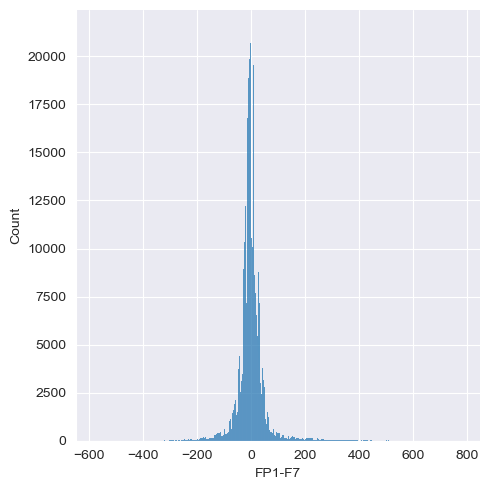

In [47]:
# Left hemisphere non_seizure
distribution_plot(data=master_data_patient_dict['Patient 1 initial set']['X no added columns']['FP1-F7'], kind='hist')

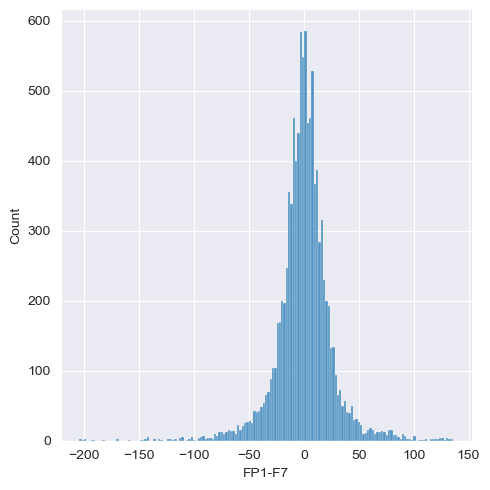

In [48]:
# Left hemisphere seizure
sns.displot(data=master_data_patient_dict['Patient 1 initial set']['y no added column']['FP1-F7'], kind='hist')

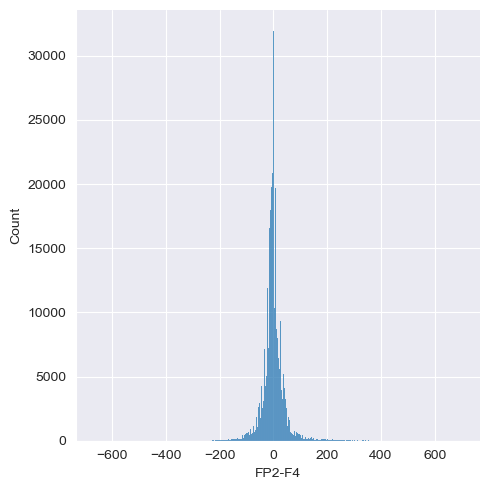

In [49]:
# Right hemisphere non-seizure
sns.displot(data=master_data_patient_dict['Patient 1 initial set']['X no added columns']['FP2-F4'], kind='hist')

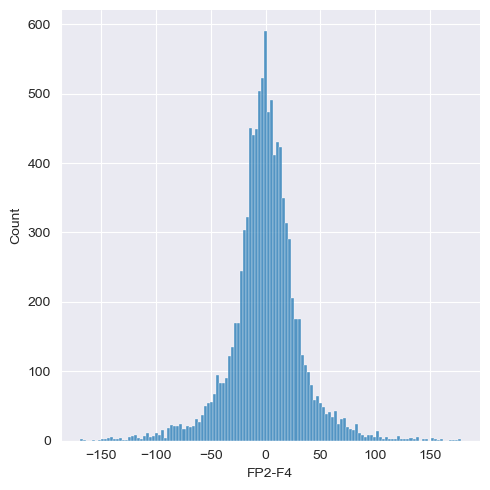

In [50]:
# Right hemisphere seizure

distribution_plot(data=master_data_patient_dict['Patient 1 initial set']['y no added column']['FP2-F4'], kind='hist')

My first inclination is to think the seizure set has a large deviation, but looking closely at the values on the x-axis shows this is not the case. Not only are the x-axis domains different when compared directly, the counts are vastly different.

Is the X set too big?

Let's eyeball some actual numbers.

We'll start with basic descriptions of the X and Y datasets then move to the X an y summary datasets.

 The two datasets without the added features and their associated non-linear regression fits.

In [51]:
# Raw data .describe() data frames joined with corresponding features side by side for analysis.
individuals = compare_describe_methods('X no added columns', 'y no added column')
individuals

,25%x,25%y,50%x,50%y,75%x,75%y,countx,county,maxx,maxy,meanx,meany,minx,miny,stdx,stdy
FP1-F7,-18.559219,-11.135531,-0.586081,0.195360,16.605617,11.916972,1688576.0,10241.0,779.291819,135.775336,0.230753,0.162015,-580.415140,-204.542125,54.740631,26.069786
F7-T7,-13.089133,-10.354090,0.195360,0.586081,13.089133,11.526252,1688576.0,10241.0,554.236874,91.623932,0.204007,0.078003,-436.239316,-116.239316,31.635561,21.236988
T7-P7,-12.698413,-10.744811,0.195360,0.195360,13.089133,11.916972,1688576.0,10241.0,390.525031,81.855922,0.188780,0.312412,-453.431013,-96.703297,24.839441,19.825202
P7-O1,-11.526252,-11.526252,0.195360,0.195360,11.916972,12.307692,1688576.0,10241.0,221.343101,98.656899,0.236891,0.374677,-304.957265,-76.385836,21.224226,20.283379
FP1-F3,-21.294261,-14.652015,-0.586081,0.195360,18.949939,16.605617,1688576.0,10241.0,674.578755,137.338217,0.225937,0.303141,-619.096459,-133.821734,52.827309,31.127361
F3-C3,-14.652015,-15.042735,0.195360,0.586081,15.433455,15.042735,1688576.0,10241.0,251.819292,201.025641,0.148782,-0.049350,-279.560440,-183.052503,26.156212,31.956879
C3-P3,-10.744811,-10.744811,0.195360,0.195360,11.135531,11.526252,1688576.0,10241.0,208.840049,83.418803,0.211710,0.307338,-224.468864,-87.716728,18.239619,18.688414
P3-O1,-14.652015,-14.261294,-0.195360,-0.195360,14.261294,15.042735,1688576.0,10241.0,233.064713,120.537241,0.265594,0.382041,-245.177045,-99.438339,24.151397,24.295570
FP2-F8,-16.996337,-12.698413,-0.195360,0.195360,15.824176,13.479853,1688576.0,10241.0,608.156288,126.788767,0.222413,0.104557,-555.409035,-162.344322,44.050657,26.606800
F8-T8,-15.824176,-13.870574,-0.586081,0.195360,15.042735,14.261294,1688576.0,10241.0,383.882784,130.695971,0.207983,0.037447,-412.405372,-134.603175,32.992028,26.137961


<AxesSubplot:xlabel='meanx', ylabel='meany'>

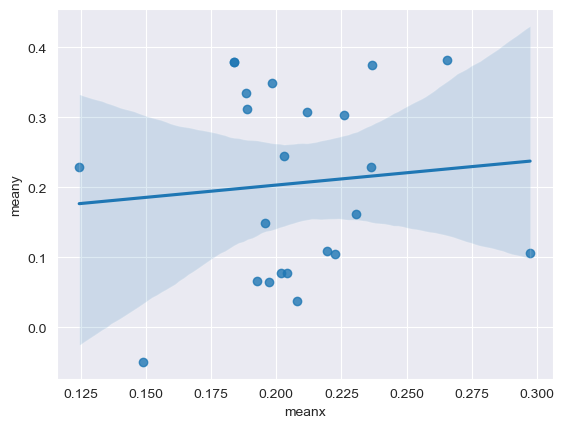

In [52]:
 sns_line(data=individuals, x='meanx', y='meany')

<AxesSubplot:xlabel='stdx', ylabel='stdy'>

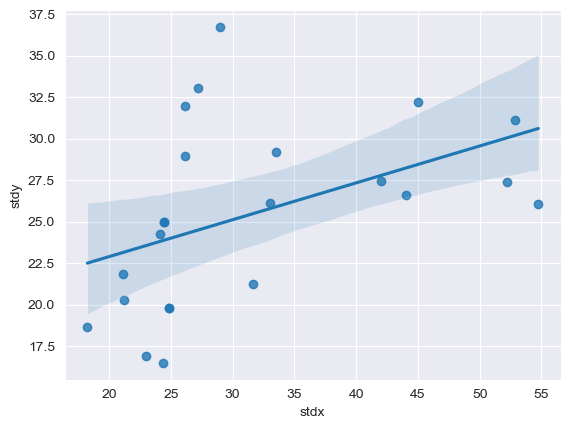

In [53]:
sns_line(data=individuals, x='stdx', y='stdy')

Nothing is jumping out of the dataframe as obvious.

Mentioned earlier is the concern about how large the X set is versus the y. My intuition was the more data in the training set the better when I model. I'm not so sure now. 1.6 million rows to 10241 is a huge difference. Now my intuition is saying that if the seizure is that short, wouldn't the aura and/or pre-auras also be at similar lengths? I'm leaning towards reducing the X set sizes to the same size as the seizure set and then getting basic summary stats on those sets chronologically leading up to the seizure. Since my hypothesis says their will be pre-auras and then auras, I will structure the 4 sets like this:

X_set_normal     ::::     X_set_pre-aura     ::::     X_set_aura     ::::     y_set_seizure

All four sets are of length 10241: the length of the y_seizure set.

The means above are close in all graphs and in the raw data and it appears the mean drops during the seizure.

It looks like there is some variation in the standard deviations, appears to be mostly larger for the X non-seizure set.

The std line plot of the standard deviations looks like a square root function: f(x) = sqrt(x), suggesting the larger the X set's std, the larger the y, albeit slowing in growth as it increases, but there is some positive correlation.

Which leads me to what could be said about "correlation" in the brain. My intuition is I'm not sure correlation will be a factor.

Each lead will be picking up energy waves from surrounding areas, saturating everything around it, at minimum in the same hemisphere. There are connections between the hemispheres, notably the Corpus Colosseum, and if that has not been severed by neurosurgeons, then electrical energy from all areas of the brain could be registered by all EEG leads.

In other words, because the brain acts non-linearly across the entire organ, correlation will not be applicable.

There is a reason that Epilepsy is in a class of unsolved mathematical problems related the Navier-Stokes Equations that offers a million dollars for a solution or proof there isn't a solution. The brain is clearly chaotic and unpredictable, as are most of nature's non-linear relationships, which is why the Bayesian analysis for a probability of a seizure should be the correct model.

But all of this may have been a primary reason for taking differences between leads, rather than the individual signal strength from each lead because the sign in front of the difference will show from which direction the energy came.

For example:

In [12]:
master_data_patient_dict['Patient 1 initial set']['X all columns'].head(1).drop('seizure = 1', axis=1)

,FP1-F7,F7-T7,T7-P7,P7-O1,outer_left_hemi_sum,FP1-F3,F3-C3,C3-P3,P3-O1,inner_left_hemi_sum,...,CZ-PZ,center_line,P7-T7,T7-FT9,left_temple_to_left_rear,FT9-FT10,temple_to_temple,FT10-T8,T8-P8-1,right_temple_to_right_rear
0,15.042735,15.042735,28.327228,-13.479853,44.932845,40.830281,-12.307692,-12.307692,28.717949,44.932845,...,-26.373626,-58.998779,-27.936508,-47.863248,-58.998779,-25.592186,-25.592186,54.896215,-27.155067,27.741148


Feature 1's  FP1-F7 is exactly what it says it is: Lean FP1 minus F7 equals the data point in milliAmps.

The first data point is positive: so the stronger signal was in the forward area of the frontal lobe and was moving toward the rear.

Then F7-T7 was again positive: the strongest waves are still moving front to back.

Next, T7-P7 is not only positive, but larger, indicating not only is the wave moving front to back, but also picked up additional energy from somewhere.

And it appears that the somewhere is from the next lead, P7-O1 whose value is negative, indicating the energy is traveling back to front, and the collision amounted to the larger number.

The total for the "outer_left_hemi_sum" is ~44, indicating the general path was front to back.

Of course this assists neurologist in identifying from where a seizure starts and maybe this knowledge will assist in establishing the "prior" in Bayes Theorem later on, but lets see if the summaries allow for any insight.

Let's see if the summary columns I added that describe the larger areas of the brain will yield anything.

In [13]:
summaries = compare_describe_methods("X only summary columns", "y only summary columns")
summaries

,25%x,25%y,50%x,50%y,75%x,75%y,countx,county,maxx,maxy,meanx,meany,minx,miny,stdx,stdy
outer_left_hemi_sum,-31.648352,-27.741148,3.552714e-15,1.562882,31.257631,30.085470,1688576.0,10241.0,822.075702,313.357753,0.860431,0.927107,-544.664225,-311.013431,72.821711,55.564994
inner_left_hemi_sum,-31.648352,-28.131868,1.776357e-15,1.562882,31.257631,30.085470,1688576.0,10241.0,820.122100,313.748474,0.852023,0.943169,-545.054945,-310.231990,72.763874,55.752882
outter_right_hemi_sum,-32.429792,-28.913309,3.907204e-01,1.562882,32.429792,31.257631,1688576.0,10241.0,963.125763,287.570208,0.812696,0.871443,-1220.610501,-330.940171,73.157846,58.344199
inner_right_hemi_sum,-32.039072,-28.913309,3.907204e-01,1.953602,32.039072,30.866911,1688576.0,10241.0,961.172161,287.960928,0.759570,0.852977,-1215.921856,-330.940171,72.805588,58.217236
center_line,-21.489621,-25.006105,3.907204e-01,1.172161,22.271062,25.006105,1688576.0,10241.0,333.284493,311.404151,0.389912,0.131779,-497.777778,-289.523810,39.011903,49.463665
left_temple_to_left_rear,-21.489621,-25.006105,3.907204e-01,1.172161,22.271062,25.006105,1688576.0,10241.0,333.284493,311.404151,0.389912,0.131779,-497.777778,-289.523810,39.011903,49.463665
temple_to_temple,-20.903541,-16.605617,-1.367521e+00,-0.195360,21.294261,16.605617,1688576.0,10241.0,583.540904,134.212454,0.297334,0.105625,-568.302808,-104.908425,52.193334,27.428797
right_temple_to_right_rear,-19.145299,-18.363858,3.907204e-01,0.781441,19.536020,20.317460,1688576.0,10241.0,393.846154,157.460317,0.403070,0.488086,-358.290598,-186.373626,37.400761,34.434195


I'm seeing some more variations in stds and means. I'll make it easier to read.

In [14]:
summaries_reduced = compare_describe_methods("X only summary columns", "y only summary columns")
summaries_reduced = summaries_reduced[['meanx', 'meany', 'stdx', 'stdy']]
summaries_reduced

,meanx,meany,stdx,stdy
outer_left_hemi_sum,0.860431,0.927107,72.821711,55.564994
inner_left_hemi_sum,0.852023,0.943169,72.763874,55.752882
outter_right_hemi_sum,0.812696,0.871443,73.157846,58.344199
inner_right_hemi_sum,0.759570,0.852977,72.805588,58.217236
center_line,0.389912,0.131779,39.011903,49.463665
left_temple_to_left_rear,0.389912,0.131779,39.011903,49.463665
temple_to_temple,0.297334,0.105625,52.193334,27.428797
right_temple_to_right_rear,0.403070,0.488086,37.400761,34.434195


It appears that the means in the outter and inner hemispheres are different. Larger in the y seizure set but the stds are less.

<AxesSubplot:xlabel='stdx', ylabel='stdy'>

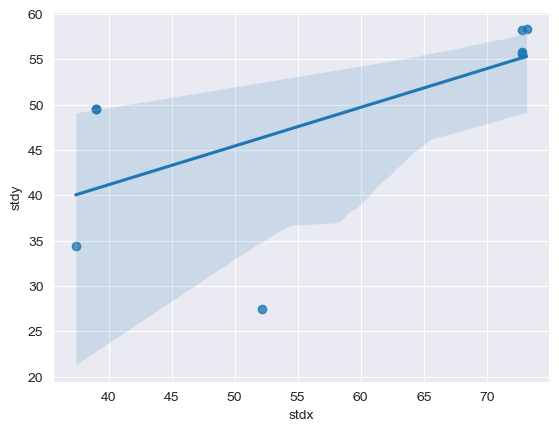

In [54]:
sns_line(data=summaries, x='stdx', y='stdy')

<AxesSubplot:xlabel='meanx', ylabel='meany'>

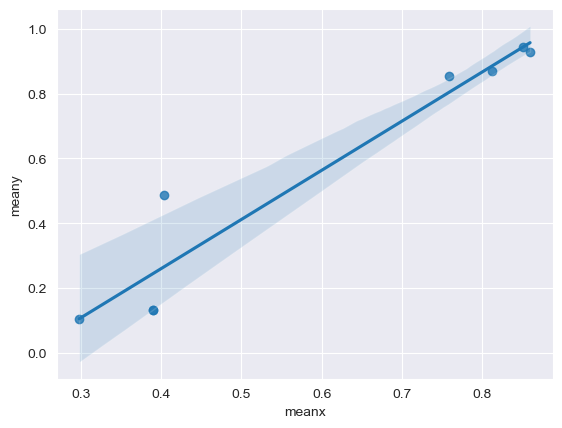

In [55]:
sns_line(data=summaries, x='meanx', y='meany')

Good correlation with the  means but not the standard deviations, opposing the earlier results of individual features. I feel it's safe to say that my hunch about the brain correlating with itself is correct and these classical summary statistics may not be the besst way to approach this capstone. But to be sure, let's see if pair plots reveal anything with the individual datasets and the summaries.

In [56]:
# sns.pairplot(data=individuals)

In [57]:
# sns.pairplot(data=summaries)

I see no patterns jumping out except chaos, as in the math of Chaos Theory, which by definition is the absence of patterns.

It's time to cut down the X into the aforementioned segments and concate them chronologically then add the y seizure set at the end

In [58]:
 patient_1_equal_data_sets_no_added_columns = equally_sized_data_sets_leading_to_seizure(
		X=master_data_patient_dict['Patient 1 initial set']['X no added columns'],
		y=master_data_patient_dict['Patient 1 initial set']['y no added column'],
		patient='Patient_1_equally_sized_data_set')

norm = patient_1_equal_data_sets_no_added_columns['X_set_normal']
pre = patient_1_equal_data_sets_no_added_columns['X_set_pre_aura']
aura = patient_1_equal_data_sets_no_added_columns['X_set_aura']
seizure = patient_1_equal_data_sets_no_added_columns['y_set_seizure']

patient_1_equal_data_sets_no_added_columns = compare_describes(
		X_norm=norm,
		X_pre_aura=pre,
		X_aura=aura,
		y_set_seizure=seizure)
patient_1_equal_data_sets_no_added_columns

((1657853, 1668093), (1668094, 1678334), (1678335, 1688575), (1688576, 1698816))


,25%_a_norm,25%_b_pre_aura,25%_c_aura,25%_seizure,50%_a_norm,50%_b_pre_aura,50%_c_aura,50%_seizure,75%_a_norm,75%_b_pre_aura,...,mean_c_aura,mean_seizure,min_a_norm,min_b_pre_aura,min_c_aura,min_seizure,std_a_norm,std_b_pre_aura,std_c_aura,std_seizure
FP1-F7,-13.089133,-11.135531,-14.652015,-11.135531,0.586081,0.195360,1.367521,0.195360,14.261294,12.307692,...,0.198451,0.162015,-133.040293,-94.358974,-186.959707,-204.542125,24.549152,20.188324,27.525639,26.069786
F7-T7,-11.916972,-11.135531,-11.916972,-10.354090,0.586081,0.195360,0.586081,0.586081,12.698413,11.526252,...,0.197039,0.078003,-150.231990,-73.260073,-113.894994,-116.239316,21.570522,19.039349,21.317217,21.236988
T7-P7,-12.307692,-11.526252,-13.479853,-10.744811,0.195360,0.586081,-0.195360,0.195360,12.307692,11.916972,...,0.055989,0.312412,-70.134310,-73.650794,-83.418803,-96.703297,20.119786,18.419991,21.650926,19.825202
P7-O1,-11.916972,-10.744811,-13.089133,-11.526252,-0.195360,0.195360,0.195360,0.195360,11.916972,11.526252,...,0.201579,0.374677,-68.180708,-93.577534,-82.637363,-76.385836,19.165587,18.489068,21.174985,20.283379
FP1-F3,-19.731380,-15.433455,-22.857143,-14.652015,0.586081,0.586081,0.586081,0.195360,19.340659,15.824176,...,0.256557,0.303141,-179.536020,-180.708181,-166.642247,-133.821734,36.902269,33.407667,38.204659,31.127361
F3-C3,-17.387057,-15.042735,-18.949939,-15.042735,0.195360,0.586081,0.976801,0.586081,18.559219,16.214896,...,0.194712,-0.049350,-206.495726,-181.489621,-192.429792,-183.052503,33.263660,29.867702,34.299291,31.956879
C3-P3,-11.526252,-10.744811,-13.870574,-10.744811,0.195360,-0.195360,0.586081,0.195360,12.307692,11.135531,...,0.070487,0.307338,-93.186813,-101.001221,-75.604396,-87.716728,20.617540,18.746571,21.920687,18.688414
P3-O1,-15.824176,-13.870574,-17.387057,-14.261294,0.195360,0.195360,0.195360,-0.195360,16.605617,13.870574,...,0.099063,0.382041,-93.968254,-90.842491,-113.894994,-99.438339,25.185773,23.617021,26.972376,24.295570
FP2-F8,-13.479853,-12.307692,-15.433455,-12.698413,0.586081,0.195360,0.976801,0.195360,14.652015,13.870574,...,0.295625,0.104557,-122.490842,-170.158730,-174.065934,-162.344322,24.882754,23.717978,27.917958,26.606800
F8-T8,-13.089133,-13.089133,-15.433455,-13.870574,0.586081,0.195360,0.976801,0.195360,13.870574,14.261294,...,0.071937,0.037447,-161.562882,-144.371184,-133.821734,-134.603175,23.438153,23.236641,25.722593,26.137961


The tuple of tuples at the top of the last output contains the 4 data sets' beginning and ending row numbers. This was only to ensure that the ending of one set was correct with the beginning of the next set with consecutive integers. ((..., 1668093), (1668094,...)) These are consecutive integers so we know the dataset indeed represents chronological time with no gaps.

LLike earlier, this is all df.describe() methods laid out linearly for easier analysis. The individual letters ensured alphabetical sorting and the last word in each feature represents from which dataset it came.

Scanning across: the counts are equal, that's good. The question is will see changes in the means and stds,so like earlier, lets cut the df down to look at just that.

In [59]:
reduced_sets = compare_describes(
		X_norm=norm,
		X_pre_aura=pre,
		X_aura=aura,
		y_set_seizure=seizure)

reduced_sets = reduced_sets[['mean_a_norm', 'mean_b_pre_aura', 'mean_c_aura', 'mean_seizure', 'std_a_norm', 'std_b_pre_aura', 'std_c_aura', 'std_seizure']]
reduced_sets

,mean_a_norm,mean_b_pre_aura,mean_c_aura,mean_seizure,std_a_norm,std_b_pre_aura,std_c_aura,std_seizure
FP1-F7,0.279220,0.218595,0.198451,0.162015,24.549152,20.188324,27.525639,26.069786
F7-T7,0.215886,0.161328,0.197039,0.078003,21.570522,19.039349,21.317217,21.236988
T7-P7,0.181892,0.218824,0.055989,0.312412,20.119786,18.419991,21.650926,19.825202
P7-O1,0.276969,0.087961,0.201579,0.374677,19.165587,18.489068,21.174985,20.283379
FP1-F3,0.246218,0.136224,0.256557,0.303141,36.902269,33.407667,38.204659,31.127361
F3-C3,0.059728,0.340912,0.194712,-0.049350,33.263660,29.867702,34.299291,31.956879
C3-P3,0.224852,0.160985,0.070487,0.307338,20.617540,18.746571,21.920687,18.688414
P3-O1,0.447968,0.116651,0.099063,0.382041,25.185773,23.617021,26.972376,24.295570
FP2-F8,0.067816,0.326185,0.295625,0.104557,24.882754,23.717978,27.917958,26.606800
F8-T8,0.399972,0.290055,0.071937,0.037447,23.438153,23.236641,25.722593,26.137961


Looking across in the mean columns let's us see if the mean is consistently going up or down.

In [60]:
patient_1_equal_data_summary_sets = equally_sized_data_sets_leading_to_seizure(
		X=master_data_patient_dict['Patient 1 initial set']["X only summary columns"],
		y=master_data_patient_dict['Patient 1 initial set']["y only summary columns"],
		patient='Patient_1_equally_sized_data_set')

norm_sum = patient_1_equal_data_summary_sets['X_set_normal']
pre_sum = patient_1_equal_data_summary_sets['X_set_pre_aura']
aura_sum = patient_1_equal_data_summary_sets['X_set_aura']
seizure_sum = patient_1_equal_data_summary_sets['y_set_seizure']

patient_1_equal_data_summary_sets = compare_describes(
		X_norm=norm_sum,
		X_pre_aura=pre_sum,
		X_aura=aura_sum,
		y_set_seizure=seizure_sum)
patient_1_equal_data_summary_sets

((1657853, 1668093), (1668094, 1678334), (1678335, 1688575), (1688576, 1698816))


,25%_a_norm,25%_b_pre_aura,25%_c_aura,25%_seizure,50%_a_norm,50%_b_pre_aura,50%_c_aura,50%_seizure,75%_a_norm,75%_b_pre_aura,...,mean_c_aura,mean_seizure,min_a_norm,min_b_pre_aura,min_c_aura,min_seizure,std_a_norm,std_b_pre_aura,std_c_aura,std_seizure
outer_left_hemi_sum,-27.741148,-26.178266,-32.429792,-27.741148,2.344322,0.781441,1.172161e+00,1.562882,31.257631,30.085470,...,0.653057,0.927107,-285.225885,-210.207570,-378.998779,-311.013431,54.719895,46.883580,55.938884,55.564994
inner_left_hemi_sum,-28.131868,-26.568987,-32.429792,-28.131868,1.953602,0.781441,1.172161e+00,1.562882,31.648352,30.476190,...,0.620818,0.943169,-285.616606,-210.989011,-379.389499,-310.231990,54.966934,47.188178,56.258168,55.752882
outter_right_hemi_sum,-29.694750,-26.178266,-33.601954,-28.913309,2.344322,3.125763,1.562882e+00,1.562882,33.211233,31.257631,...,0.547299,0.871443,-297.338217,-219.975580,-280.537241,-330.940171,56.356407,47.598342,55.639590,58.344199
inner_right_hemi_sum,-29.694750,-26.178266,-33.601954,-28.913309,2.344322,3.125763,1.953602e+00,1.953602,33.211233,31.257631,...,0.525628,0.852977,-297.728938,-219.584860,-280.146520,-330.940171,56.169211,47.491331,55.555121,58.217236
center_line,-27.350427,-23.833944,-30.476190,-25.006105,-0.390720,0.781441,1.562882e+00,1.172161,28.522589,24.615385,...,0.382747,0.131779,-272.332112,-305.152625,-301.245421,-289.523810,53.627893,46.828013,52.922024,49.463665
left_temple_to_left_rear,-27.350427,-23.833944,-30.476190,-25.006105,-0.390720,0.781441,1.562882e+00,1.172161,28.522589,24.615385,...,0.382747,0.131779,-272.332112,-305.152625,-301.245421,-289.523810,53.627893,46.828013,52.922024,49.463665
temple_to_temple,-17.387057,-15.433455,-18.559219,-16.605617,0.195360,0.195360,1.953602e-01,-0.195360,17.387057,16.214896,...,0.405466,0.105625,-133.821734,-174.065934,-128.742369,-104.908425,28.172706,26.574717,29.434567,27.428797
right_temple_to_right_rear,-19.926740,-17.191697,-20.317460,-18.363858,0.390720,0.390720,-1.776357e-15,0.781441,22.271062,17.973138,...,0.100227,0.488086,-179.340659,-130.891331,-110.964591,-186.373626,34.176710,31.011397,32.148264,34.434195


In [61]:
reduced_summary_sets = compare_describes(
		X_norm=norm_sum,
		X_pre_aura=pre_sum,
		X_aura=aura_sum,
		y_set_seizure=seizure_sum)

reduced_summary_sets = reduced_summary_sets[['mean_a_norm', 'mean_b_pre_aura', 'mean_c_aura', 'mean_seizure', 'std_a_norm', 'std_b_pre_aura', 'std_c_aura', 'std_seizure']]
reduced_summary_sets

,mean_a_norm,mean_b_pre_aura,mean_c_aura,mean_seizure,std_a_norm,std_b_pre_aura,std_c_aura,std_seizure
outer_left_hemi_sum,0.953967,0.686708,0.653057,0.927107,54.719895,46.883580,55.938884,55.564994
inner_left_hemi_sum,0.978766,0.754772,0.620818,0.943169,54.966934,47.188178,56.258168,55.752882
outter_right_hemi_sum,0.893304,1.143280,0.547299,0.871443,56.356407,47.598342,55.639590,58.344199
inner_right_hemi_sum,0.872931,1.129163,0.525628,0.852977,56.169211,47.491331,55.555121,58.217236
center_line,0.185383,0.557485,0.382747,0.131779,53.627893,46.828013,52.922024,49.463665
left_temple_to_left_rear,0.185383,0.557485,0.382747,0.131779,53.627893,46.828013,52.922024,49.463665
temple_to_temple,-0.077392,0.094180,0.405466,0.105625,28.172706,26.574717,29.434567,27.428797
right_temple_to_right_rear,0.581903,0.541690,0.100227,0.488086,34.176710,31.011397,32.148264,34.434195


It's important to remember that each data point is a sum of the differences in the EEG leads.

Looking at the left hemisphere sums, the sums are dropping through time as it gets closer to the seizure then jumps at the seizure.

In the right hemisphere, the sums increase, then decrease, during the aura, then jumps.

The center line decreases at the seizure, along with left temple nad temple to temple, but right temple to rear increases.

I like to plot these rows going across the time scale to look for consistencies.

master_data_patient_dict['Patient 1 initial set'].keys()

In [62]:
program_functions

['compare_describe_methods(dfx,dfy)',
 ' sns_line(data,x,y',
 'equally_sized_data_sets_leading_to_seizure(X: str, y: str, patient: str)',
 'compare_describes(**kwargs)',
 'distribution_plot(data=None, kind="hist")']

Let's look at the plots for the new dfs: norm, pre, aura and seizure

<seaborn.axisgrid.FacetGrid object at 0x1637ee5c0> <seaborn.axisgrid.FacetGrid object at 0x16aa97790> <seaborn.axisgrid.FacetGrid object at 0x169588f40> <seaborn.axisgrid.FacetGrid object at 0x173707ac0>


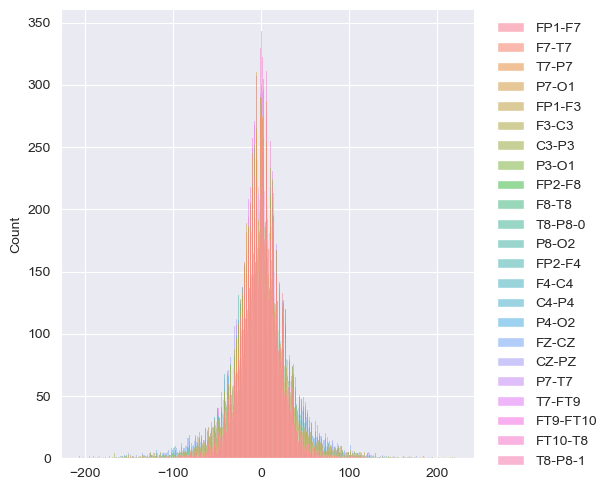

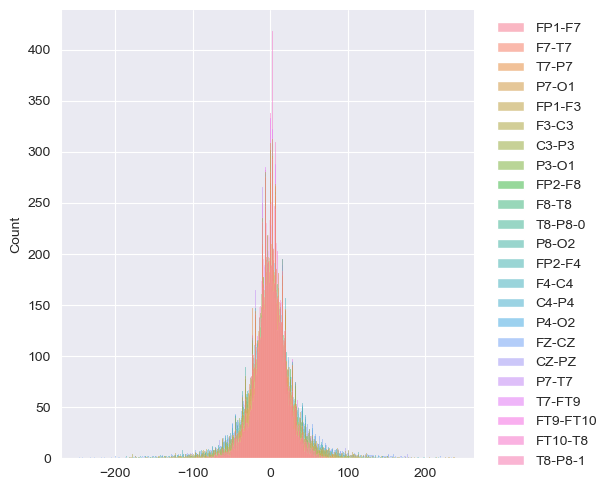

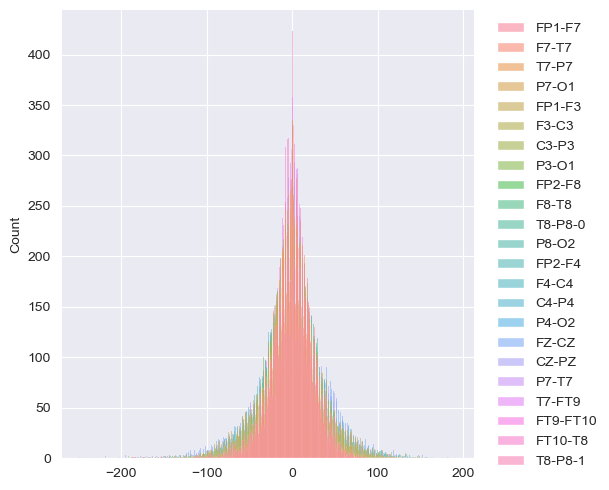

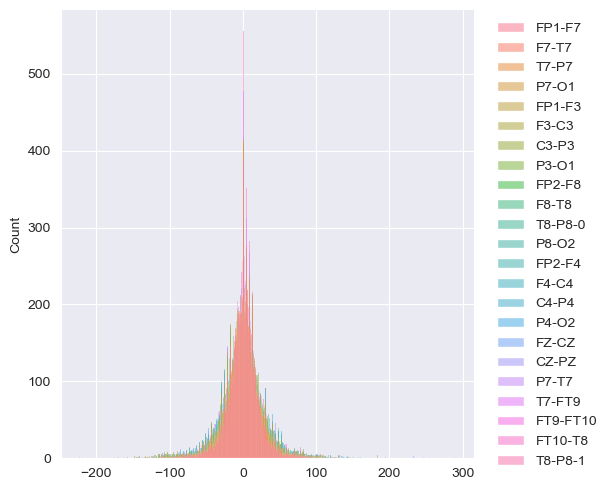

In [63]:
n, p, a, s = distribution_plot(data=norm, kind='hist', legend = True), \
			 distribution_plot(data=pre, kind='hist', legend = True), \
			 distribution_plot(data=aura, kind='hist', legend = True), \
			 distribution_plot(data=seizure, kind='hist', legend = True)

print(n, p, a, s)

Let's compare the three sets' means versus the seizure means in each EEG lead in order as they occur.
Starting with the the set furthest out from the seizure:

norm v. seizure ->>>>>> pre_aura v. seizure ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_seizure'>

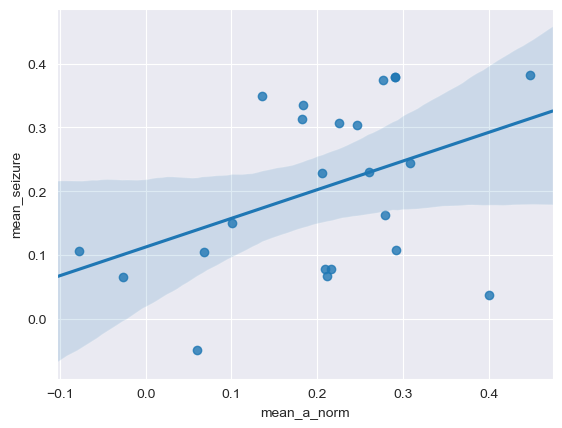

In [86]:
sns_line(reduced_sets, 'mean_a_norm', 'mean_seizure',  truncate=False, logx=False)

The means are slightly correlated. The seizure mean rises as the set's mean rises, although we know this is the set furthest out from the seizure.

Now the next set, where I hope to identify a pre_aura.

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_seizure'>

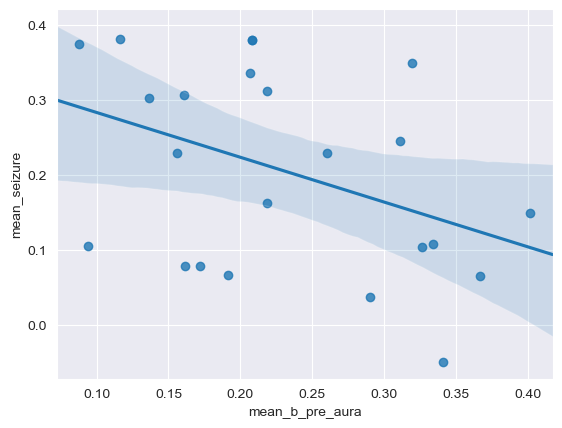

In [90]:
sns_line(reduced_sets, 'mean_b_pre_aura', 'mean_seizure',truncate=False, logx=False)

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_seizure'>

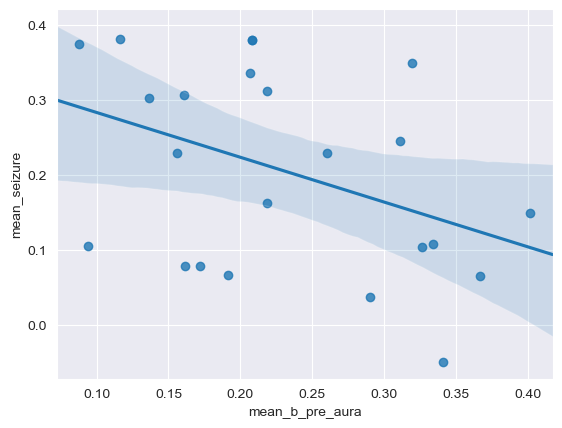

In [99]:
sns_line(reduced_sets, 'mean_b_pre_aura', 'mean_seizure', truncate=False, logx=False)

The mean decreases in the pre-aura phase as the mean for seizure decrease, opposite the previous set.

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

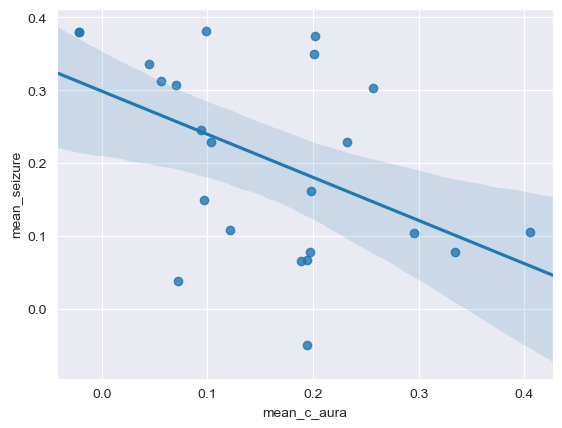

In [101]:
sns_line(reduced_sets, 'mean_c_aura', 'mean_seizure', truncate=False, logx=False)

And that trend continues with the set just before the seizure.

Lets link them chronologically starting with the set furthest out.

Note the y-axis represents the set closest to the seizure.

norm v. pre-aura ->>>>>> pre_aura v. aura ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_b_pre_aura'>

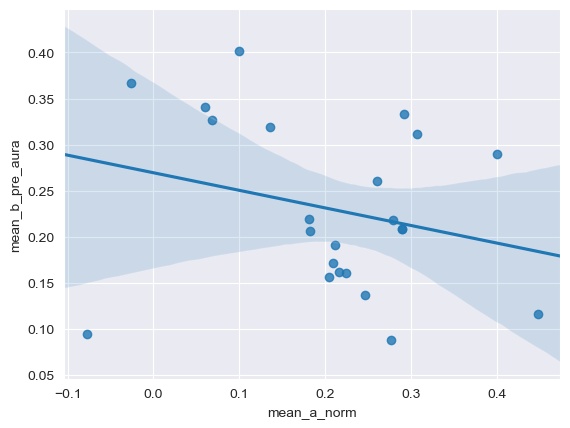

In [102]:
sns_line(reduced_sets, 'mean_a_norm', 'mean_b_pre_aura', truncate=False, logx=False)

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_c_aura'>

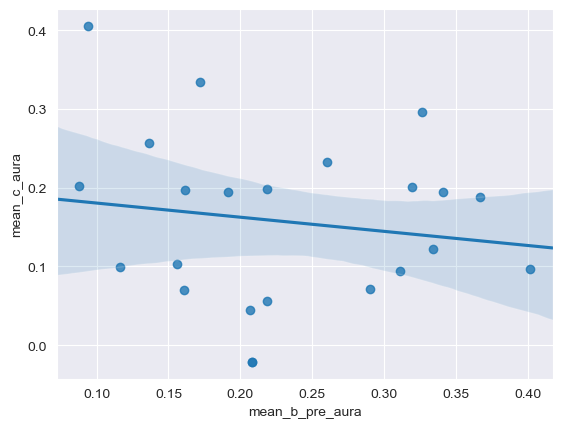

In [78]:
sns_line(reduced_sets, 'mean_b_pre_aura', 'mean_c_aura', truncate=False, logx=False)

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

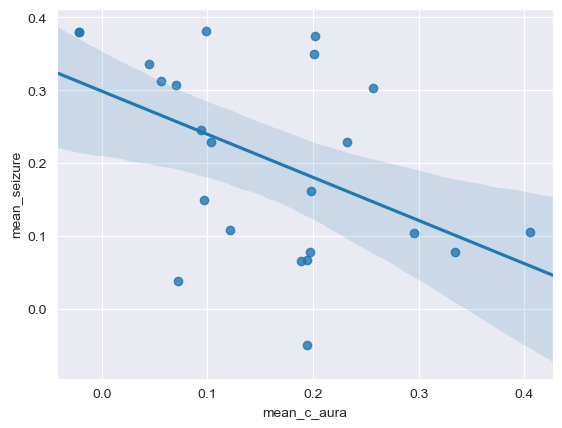

In [80]:
sns_line(reduced_sets, 'mean_c_aura', 'mean_seizure', truncate=False, logx=False)

Generally, the mean from the first set (furthest from the seizure) is increasing as the mean from the second set (closest to the seizure) is decreasing and this pattern continues all the way through the seizure, or the means are decreasing all the way through the seizure. And that was the pattern seen earlier. Her it is again for convenience.

In [93]:
reduced_sets

,mean_a_norm,mean_b_pre_aura,mean_c_aura,mean_seizure,std_a_norm,std_b_pre_aura,std_c_aura,std_seizure
FP1-F7,0.279220,0.218595,0.198451,0.162015,24.549152,20.188324,27.525639,26.069786
F7-T7,0.215886,0.161328,0.197039,0.078003,21.570522,19.039349,21.317217,21.236988
T7-P7,0.181892,0.218824,0.055989,0.312412,20.119786,18.419991,21.650926,19.825202
P7-O1,0.276969,0.087961,0.201579,0.374677,19.165587,18.489068,21.174985,20.283379
FP1-F3,0.246218,0.136224,0.256557,0.303141,36.902269,33.407667,38.204659,31.127361
F3-C3,0.059728,0.340912,0.194712,-0.049350,33.263660,29.867702,34.299291,31.956879
C3-P3,0.224852,0.160985,0.070487,0.307338,20.617540,18.746571,21.920687,18.688414
P3-O1,0.447968,0.116651,0.099063,0.382041,25.185773,23.617021,26.972376,24.295570
FP2-F8,0.067816,0.326185,0.295625,0.104557,24.882754,23.717978,27.917958,26.606800
F8-T8,0.399972,0.290055,0.071937,0.037447,23.438153,23.236641,25.722593,26.137961


I need a sanity check. I chose quite the capstone project and sometimes I feel like I'm moving aimlessly. I need to make sure the laws of the universe still apply. Lets do the plot with only the seizure set.

<AxesSubplot:xlabel='mean_seizure', ylabel='mean_seizure'>

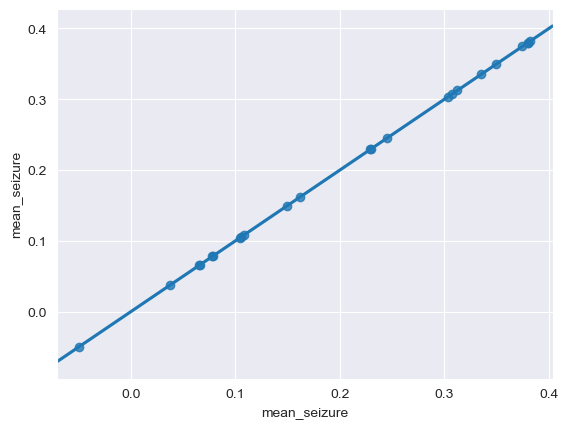

In [109]:
sns_line(reduced_sets, 'mean_seizure', 'mean_seizure', truncate=False, logx=False)

I'm still sane. Nothing to hint that I've moved into another universe  in the multiverse.

So let's do the same thing for the summary columns which shows.

Here is the set for convenience.

In [94]:
reduced_summary_sets

,mean_a_norm,mean_b_pre_aura,mean_c_aura,mean_seizure,std_a_norm,std_b_pre_aura,std_c_aura,std_seizure
outer_left_hemi_sum,0.953967,0.686708,0.653057,0.927107,54.719895,46.883580,55.938884,55.564994
inner_left_hemi_sum,0.978766,0.754772,0.620818,0.943169,54.966934,47.188178,56.258168,55.752882
outter_right_hemi_sum,0.893304,1.143280,0.547299,0.871443,56.356407,47.598342,55.639590,58.344199
inner_right_hemi_sum,0.872931,1.129163,0.525628,0.852977,56.169211,47.491331,55.555121,58.217236
center_line,0.185383,0.557485,0.382747,0.131779,53.627893,46.828013,52.922024,49.463665
left_temple_to_left_rear,0.185383,0.557485,0.382747,0.131779,53.627893,46.828013,52.922024,49.463665
temple_to_temple,-0.077392,0.094180,0.405466,0.105625,28.172706,26.574717,29.434567,27.428797
right_temple_to_right_rear,0.581903,0.541690,0.100227,0.488086,34.176710,31.011397,32.148264,34.434195


And the layout, like above, looks like this.

norm v. seizure ->>>>>> pre_aura v. seizure ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_seizure'>

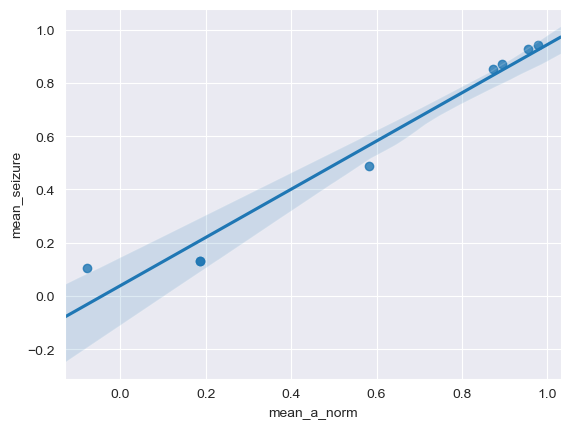

In [103]:
sns_line(reduced_summary_sets, 'mean_a_norm', 'mean_seizure',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_seizure'>

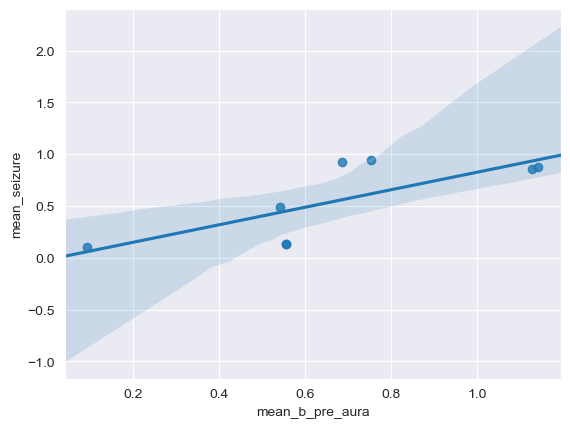

In [104]:
sns_line(reduced_summary_sets, 'mean_b_pre_aura', 'mean_seizure',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

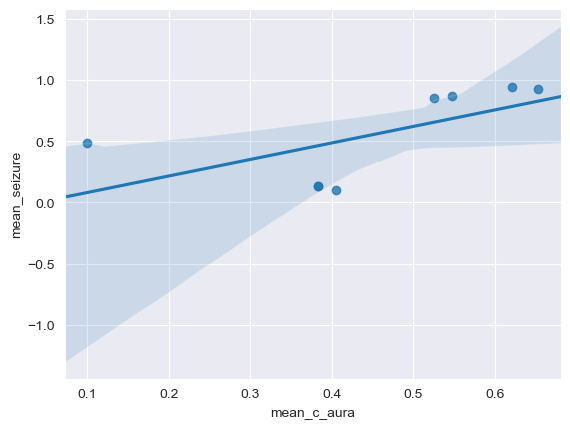

In [105]:
sns_line(reduced_summary_sets, 'mean_c_aura', 'mean_seizure',  truncate=False, logx=False)

The pattern is the same in the summary columns. All of the sets in time show increasing means compared to the seizure.

Lets link them chronologically starting with the set furthest out as we did earlier but this time with the summaries.

Note the y-axis represents the set closest to the seizure.

norm v. pre-aura ->>>>>> pre_aura v. aura ->>>>>> aura v. seizure

<AxesSubplot:xlabel='mean_a_norm', ylabel='mean_b_pre_aura'>

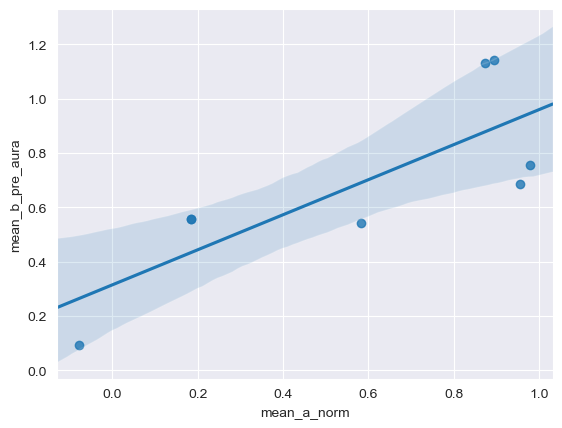

In [106]:
sns_line(reduced_summary_sets, 'mean_a_norm', 'mean_b_pre_aura',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_b_pre_aura', ylabel='mean_c_aura'>

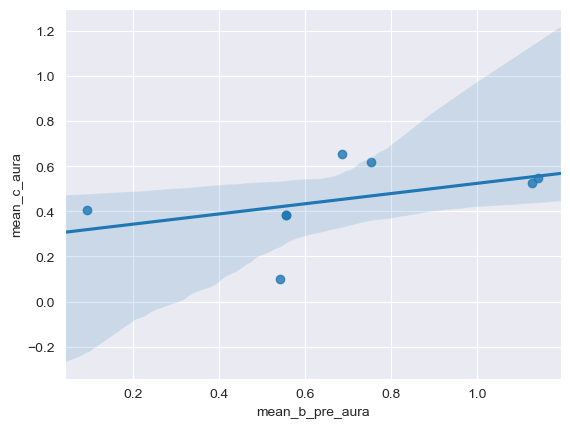

In [107]:
sns_line(reduced_summary_sets, 'mean_b_pre_aura', 'mean_c_aura',  truncate=False, logx=False)

<AxesSubplot:xlabel='mean_c_aura', ylabel='mean_seizure'>

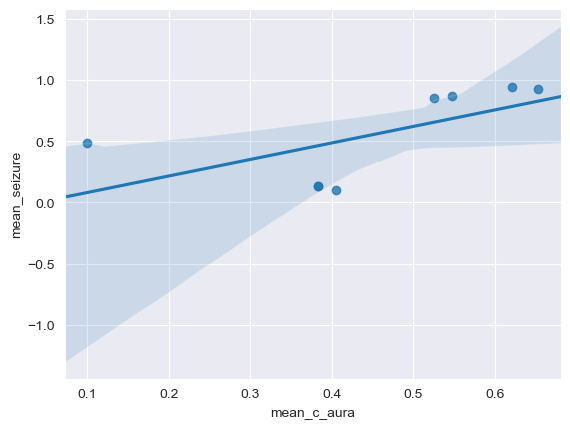

In [108]:
sns_line(reduced_summary_sets, 'mean_c_aura', 'mean_seizure',  truncate=False, logx=False)

Means increasing and maybe it was doing it earlier and I didn't notice, but seems like the increase slowed in the transition from pre_aura to aura and picked up ever so slightly again in the transition to the seizure.

Would this mean there is a lessening in enaergy just before the increase in the auras that patients claim to fell.

Scrolling back up to the raw data, there was a leveling off in the same plot before stepping again in the aura.

We'll keep this in mind moving forward.

To pandas quantiles.